In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import os
import pandas as pd

In [49]:
# load the mapping file that matches the encoded class number to the source image
with open('images.json', 'r') as f:
     imgdict = json.load(f)

In [50]:
# housekeeping

# directory where the model is saved
model_path = "/mnt/copyright/"

# directory containing test images
test_dir = os.path.join(model_path, 'test')

# load the labels of the retrained model 
labels = [line.rstrip() for line
                in tf.gfile.GFile(os.path.join(model_path, "retrained_labels.txt"))]

# path to the saved graph (model)
graph_path = os.path.join(model_path, "retrained_graph.pb")

In [51]:
# connect to the trained model
def load_graph(graph_filename):
    with tf.gfile.FastGFile(graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='my_graph')

In [52]:
# visualize a few results
def view_results(df, variables, n_rows, n_cols):   
    fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    r = {}
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        plt.tight_layout()
        ax.imshow(df[i])
        ax.set_title("%s" % (var_name))     
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    return r

In [53]:
# display a sample
def collect_results(mydf, mymap):
    sd = []
    sd_labels = []
    for index, image_path in mydf.iterrows():
        distortion = mpimg.imread(image_path.name)

        actual_image_path = '/mnt/gcs/' + mymap[image_path.actual_class][0]
        actual_image = mpimg.imread(actual_image_path)

        predicted_image_path = '/mnt/gcs/' + mymap[image_path.predicted_class][0]
        predicted_image = mpimg.imread(predicted_image_path)

        sd.append(distortion)
        sd.append(actual_image)
        sd.append(predicted_image)

        sd_labels.append("distortion    "+ image_path.name)
        sd_labels.append("actual    " + actual_image_path)
        sd_labels.append("predicted    " + predicted_image_path)
    return sd, sd_labels

In [54]:
# connect to the trained model
load_graph(graph_path)

# create a list of all test images
test_list = []
for (dirpath, dirnames, filenames) in os.walk(test_dir):
    for name in filenames:
        test_list.append(os.path.join(dirpath, name))
        
# evaluate the images and save the predictions to a dictionary
results = {}

In [61]:
%%time
with tf.Session() as sess:
    for image_path in test_list:
        image_data = tf.gfile.FastGFile(image_path, "rb").read()
        softmax_tensor = sess.graph.get_tensor_by_name("my_graph/final_result:0")
        predictions, = sess.run(softmax_tensor, {"my_graph/DecodeJpeg/contents:0": image_data})
        most_probable = predictions.argsort()[-1:][::-1]
        label = str.split(labels[most_probable[0]],' ')[1]
        score = predictions[most_probable[0]]
        actual = str.split(os.path.split(os.path.dirname(image_path))[1],'_')[1]
        results[image_path] = {'actual_class': actual, 'predicted_class': label, 'score': score}
        

CPU times: user 19min 27s, sys: 4.64 s, total: 19min 31s
Wall time: 9min 54s


In [56]:
# display a sample as a dataframe
df = pd.DataFrame.from_dict(results, 'index')
df.sample(5)

,actual_class,score,predicted_class
/mnt/copyright/test/class_72/test_copy_0.jpg,72,0.963576,72
/mnt/copyright/test/class_4/test_copy_2.jpg,4,0.884429,4
/mnt/copyright/test/class_35/test_copy_3.jpg,35,0.985240,35
/mnt/copyright/test/class_77/test_copy_5.jpg,77,0.881470,77
/mnt/copyright/test/class_48/test_copy_8.jpg,48,0.985548,48


In [57]:
# print an accuracy metric
num_correct = df[df['actual_class'] == df['predicted_class']].shape[0]
total = df.shape[0]
print(str(num_correct) + " of " + str(total) + " images correctly recognized: " \
      + str(100*float(num_correct)/total) + "% accuracy")

807 of 820 images correctly recognized: 98.4146341463% accuracy


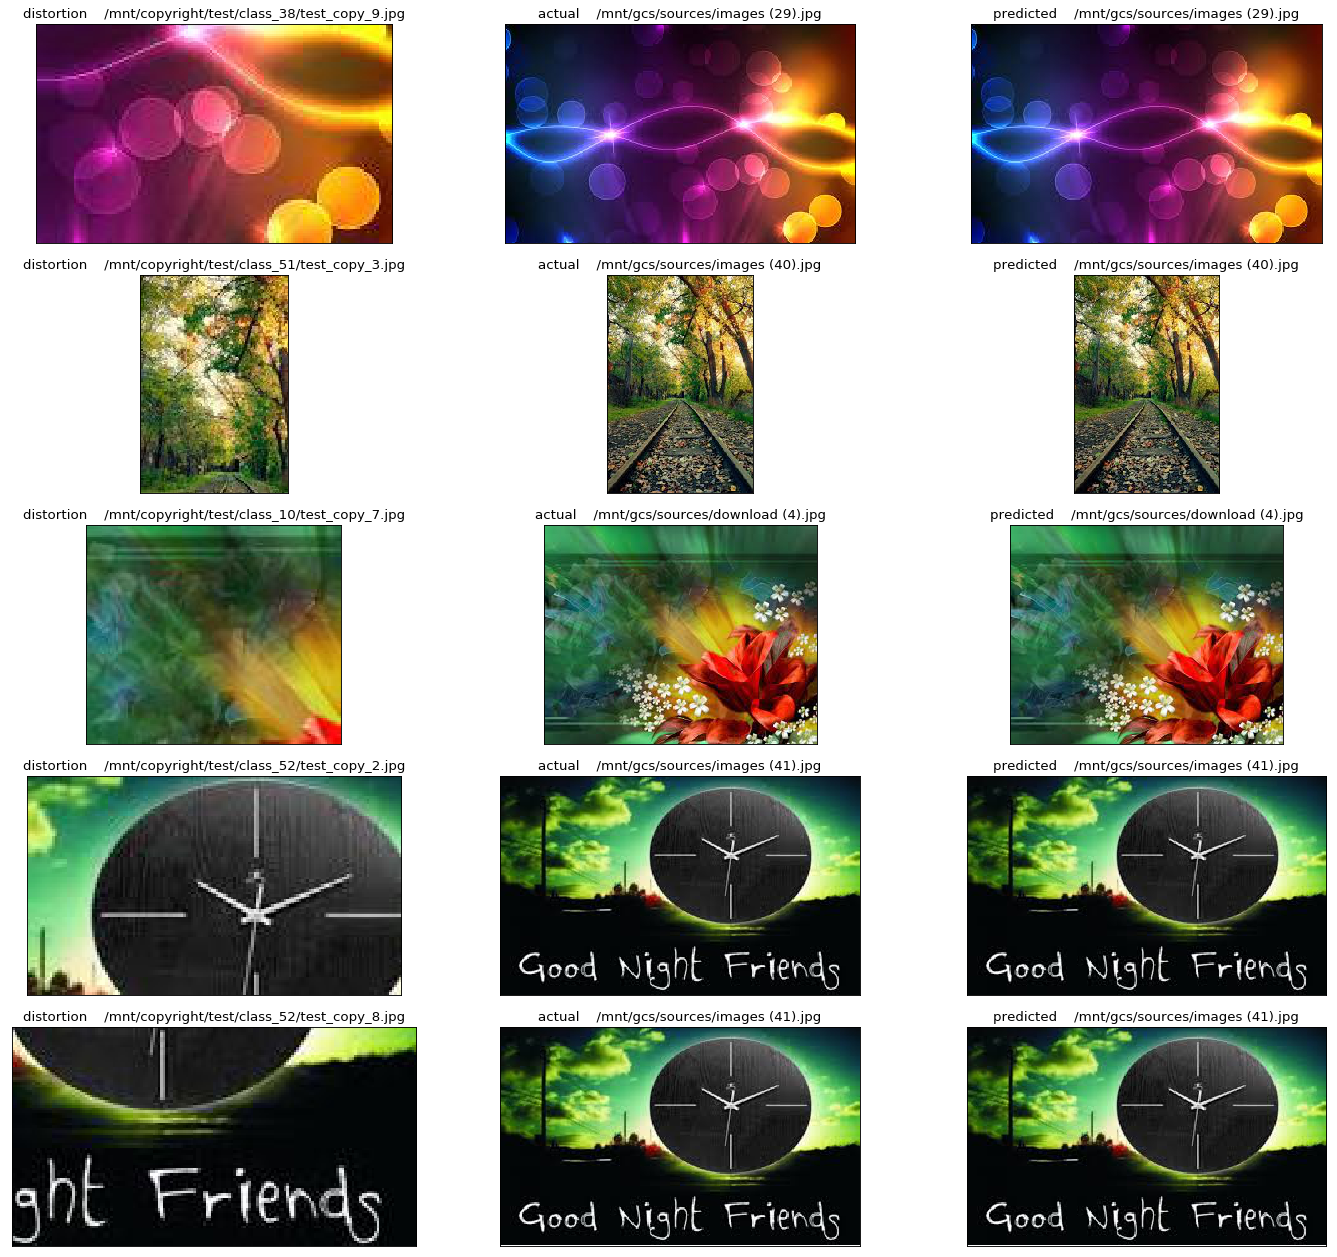

In [59]:
# visualize a sample
sample_n = 5

# show the images that were correctly recognized
df_correct = df[df['actual_class'] == df['predicted_class']].sample(sample_n)
correct_imgs, correct_labels = collect_results(df_correct, imgdict)
correct_grid = view_results(correct_imgs, correct_labels, sample_n, 3)

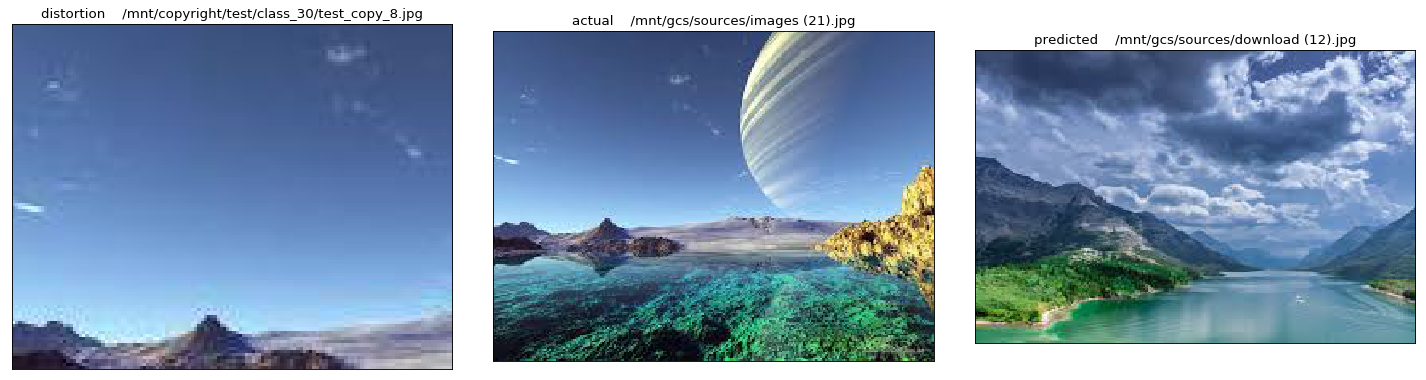

In [60]:
# show an image that was wrongly recognized
s = '/mnt/copyright/test/class_30/test_copy_8.jpg'
dw = df[df['actual_class'] != df['predicted_class']]
df_wrong = dw.loc[s:]
wrong_imgs, wrong_labels = collect_results(df_wrong, imgdict)
wrong_grid = view_results(wrong_imgs[0:3], wrong_labels[0:3], 1, 3)
#df_wrong = df[df['actual_class'] != df['predicted_class']].sample(sample_n)
#wrong_grid = view_results(wrong_imgs, wrong_labels, 5, 3)